In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [17]:
Class8 = pd.read_csv('C:/Users/wjssm/Desktop/lpoint/modeling/Class8.csv')
Class8['Date'] = pd.date_range('2018-04-01', '2018-09-30').strftime('%Y-%m-%d')
Class8['Date'] =pd.to_datetime(Class8['Date'])
Class8 = Class8.set_index('Date')
Class8.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,fashion
Date,,,,,
2018-04-01,1995,75.125000,1653.928679,35.157186,383.777778
2018-04-02,1910,65.013571,1505.189787,35.250212,356.888889
2018-04-03,2036,76.665635,1659.884914,35.386997,349.555556
2018-04-04,1419,60.346078,1288.602362,34.333333,339.777778
2018-04-05,1946,66.628085,1465.965870,34.936170,325.111111


In [18]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    diff.append(dataset[0])
    for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
    return pd.Series(diff)

# inverse_difference
def inverse_difference(diff, interval=1):
    origin = list()
    origin.append(diff[0])
    for i in range(interval, len(diff)):
            value = diff[i] + origin[i - interval]
            origin.append(value)
    return pd.Series(origin)

In [19]:
Y = Class8['BUY_CT_sum']

In [20]:
#remove original Y
Class8.drop(columns=['BUY_CT_sum'],inplace=True)
Class8.rename(columns = {'fashion' : 'naver_click'}, inplace=True)
Class8.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2018-04-01,75.125000,1653.928679,35.157186,383.777778
2018-04-02,65.013571,1505.189787,35.250212,356.888889
2018-04-03,76.665635,1659.884914,35.386997,349.555556
2018-04-04,60.346078,1288.602362,34.333333,339.777778
2018-04-05,66.628085,1465.965870,34.936170,325.111111


In [21]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm

#### 변수 조합

In [23]:
#TOT_SESS_HR_V_mean 역수
Class8['TOT_SESS_HR_V_mean'] = 1000/Class8['TOT_SESS_HR_V_mean']
Class8.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2018-04-01,75.125000,0.604621,35.157186,383.777778
2018-04-02,65.013571,0.664368,35.250212,356.888889
2018-04-03,76.665635,0.602451,35.386997,349.555556
2018-04-04,60.346078,0.776035,34.333333,339.777778
2018-04-05,66.628085,0.682144,34.936170,325.111111


#### scaled

In [24]:
scaled_df1=minmax(Class8)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2018-04-01,0.339109,0.348601,0.438001,0.797101
2018-04-02,0.172400,0.517906,0.466061,0.637681
2018-04-03,0.364509,0.342453,0.507319,0.594203
2018-04-04,0.095446,0.834335,0.189505,0.536232
2018-04-05,0.199018,0.568278,0.371337,0.449275


In [25]:
scaled_Y = minmax(Y)

scaled_df1 = pd.concat([scaled_df1, scaled_Y], axis = 1)
scaled_df1.rename(columns={'BUY_CT_sum':'Y'}, inplace=True)

scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click,Y
Date,,,,,
2018-04-01,0.339109,0.348601,0.438001,0.797101,0.587984
2018-04-02,0.172400,0.517906,0.466061,0.637681,0.555039
2018-04-03,0.364509,0.342453,0.507319,0.594203,0.603876
2018-04-04,0.095446,0.834335,0.189505,0.536232,0.364729
2018-04-05,0.199018,0.568278,0.371337,0.449275,0.568992


#### modeling

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\Users\wjssm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
#scaled_data : scaled한 데이터. 사용하려는 변수 + 마지막 칼럼은 Y
#n : 사용하는 변수 개수

scaled_data = scaled_df1
n = 4

In [67]:
scaled_Y = scaled_data['Y']

values = scaled_df1.values
# frame as supervised learning
reframed = series_to_supervised(scaled_df1, 1, 1)
reframed.drop(reframed.columns[-(n+1):-1], axis=1,inplace = True)

# split into train and test sets
values = reframed.values
n_train = int(len(scaled_data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [68]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(loss='mse', optimizer='Adagrad')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 128 samples, validate on 54 samples
Epoch 1/200
 - 4s - loss: 0.1853 - val_loss: 0.0797
Epoch 2/200
 - 0s - loss: 0.1023 - val_loss: 0.0474
Epoch 3/200
 - 0s - loss: 0.0741 - val_loss: 0.0347
Epoch 4/200
 - 0s - loss: 0.0659 - val_loss: 0.0303
Epoch 5/200
 - 0s - loss: 0.0718 - val_loss: 0.0283
Epoch 6/200
 - 0s - loss: 0.0523 - val_loss: 0.0266
Epoch 7/200
 - 0s - loss: 0.0651 - val_loss: 0.0263
Epoch 8/200
 - 0s - loss: 0.0637 - val_loss: 0.0263
Epoch 9/200
 - 0s - loss: 0.0611 - val_loss: 0.0265
Epoch 10/200
 - 0s - loss: 0.0725 - val_loss: 0.0274
Epoch 11/200
 - 0s - loss: 0.0583 - val_loss: 0.0271
Epoch 12/200
 - 0s - loss: 0.0853 - val_loss: 0.0273
Epoch 13/200
 - 0s - loss: 0.0761 - val_loss: 0.0273
Epoch 14/200
 - 0s - loss: 0.0557 - val_loss: 0.0266
Epoch 15/200
 - 0s - loss: 0.0852 - val_loss: 0.0272
Epoch 16/200
 - 0s - loss: 0.0831 - val_loss: 0.0272
Epoch 17/200
 - 0s - loss: 0.0672 - val_loss: 0.0270
Epoch 18/200
 - 0s - loss: 0.0724 - val_loss: 0.0269
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0633 - val_loss: 0.0334
Epoch 155/200
 - 0s - loss: 0.0634 - val_loss: 0.0337
Epoch 156/200
 - 0s - loss: 0.0647 - val_loss: 0.0337
Epoch 157/200
 - 0s - loss: 0.0657 - val_loss: 0.0338
Epoch 158/200
 - 0s - loss: 0.0737 - val_loss: 0.0338
Epoch 159/200
 - 0s - loss: 0.0693 - val_loss: 0.0337
Epoch 160/200
 - 0s - loss: 0.0543 - val_loss: 0.0336
Epoch 161/200
 - 0s - loss: 0.0648 - val_loss: 0.0335
Epoch 162/200
 - 0s - loss: 0.0703 - val_loss: 0.0339
Epoch 163/200
 - 0s - loss: 0.0548 - val_loss: 0.0338
Epoch 164/200
 - 0s - loss: 0.0474 - val_loss: 0.0337
Epoch 165/200
 - 0s - loss: 0.0670 - val_loss: 0.0339
Epoch 166/200
 - 0s - loss: 0.0586 - val_loss: 0.0337
Epoch 167/200
 - 0s - loss: 0.0734 - val_loss: 0.0338
Epoch 168/200
 - 0s - loss: 0.0686 - val_loss: 0.0339
Epoch 169/200
 - 0s - loss: 0.0437 - val_loss: 0.0338
Epoch 170/200
 - 0s - loss: 0.0490 - val_loss: 0.0339
Epoch 171/200
 - 0s - loss: 0.0639 - val_loss: 0.0339
Epoch 172/200
 - 0s - loss: 

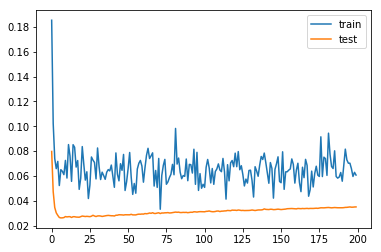

In [69]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [70]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
true_Y = Y.values[n_train+1:].reshape(yhat.shape[0],1)

In [71]:
# invert scaling for forecast
dfhat = np.concatenate((true_Y,yhat), axis = 1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,1],dfhat[:,0])

# calculate RMSE
rmse = np.sqrt(mean_squared_error(true_Y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 483.467


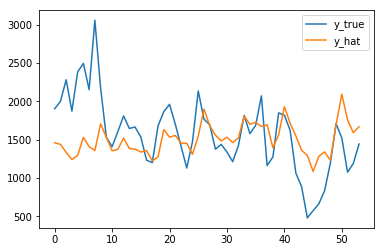

In [72]:
plt.plot(true_Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat')
plt.legend()

In [73]:
inv_yhat = pd.Series(inv_yhat)
inv_yhat.index = Y[n_train+1:,].index

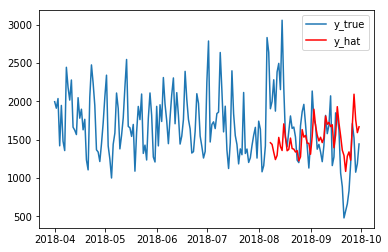

In [74]:
plt.plot(Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat', c='r')
plt.legend()